Globally averaged temperature:

$$
\frac{dT}{dt} = R_i(T) -  R_0(T, C)
$$


$$
R_i(T) = \frac{Q_0}{c} (1 - p \alpha_\text{land} - p \alpha_\text{oc}(T)) 
$$

$$
R_o(T) = \frac{1}{c} (\kappa (T - T_\kappa) - a \ln (\frac{C}{C_0}) )
$$


Accumulated anthropogenic carbon, $S_a$
$$
\frac{d S_a}{dt} = C_a
$$

Atmospheric carbon concentration:

$$
\frac{dC}{dt} = v + C_a - W_a A_v C g^{vege}(T) + \frac{c_0}{\tau_c} \kappa_P (1 - f(T)) + \frac{c_0}{\tau_c} \kappa_B(S_a) (1 - f(T)) - \frac{\lambda}{\tau_c} C(1 - f(T))
$$

Temperature anomaly:
$$
\tilde{T} = T - T_{preindustrial}
$$



$$
\begin{align}
\delta \phi(\tilde{T}, C, S_a) =& \max_{C_a} \eta \log C_a  \\
& + \frac{d \phi (\tilde{T}, C, S_a)}{d\tilde{T}} \left( R_i(T) - R_0(T, C) \right)\\
& + \frac{d\phi(\tilde{T}, C, S_a)}{d C} \left( v + C_a - W_a A_v C g^{vege}(T) + \frac{c_0}{\tau_c} \kappa_P (1 - f(T)) + \frac{c_0}{\tau_c} \kappa_B(S_a) (1 - f(T)) - \frac{\lambda}{\tau_c} C(1 - f(T))\right)\\
& + \frac{d \phi (\tilde{T}, C, S_a)}{d S_a} C_a \\
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 \tilde{T}) (R_i(T) - R_0(T, C))
\end{align}
$$

$$
C_a^{*} = - \frac{ \eta}{\frac{d \phi (\tilde{T}, C, S_a)}{d C} + \frac{d \phi (\tilde{T}, C, S_a)}{d S_a} }
$$

In [1]:
import sys
sys.path.append("../src/")
import numpy as np
import pandas as pd
import pickle
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import SymLogNorm
import matplotlib.mlab
import scipy.io as sio
import pandas as pd
import scipy.optimize as optim
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy import fft, arange, signal
from scipy.interpolate import RegularGridInterpolator
import SolveLinSys
from supportfunctions import finiteDiff
rcParams["figure.figsize"] = (8,5)
rcParams["savefig.bbox"] = 'tight'
                                                                                
def PDESolver(stateSpace, A, B1, B2, B3, C1, C2, C3, D, v0, 
              ε = 1, tol = -10):                                              
                                                                                 

    A = A.reshape(-1,1,order = 'F')                                         
    B = np.hstack([B1.reshape(-1,1,order = 'F'),B2.reshape(-1,1,order = 'F'),B3.reshape(-1,1,order='F')])
    C = np.hstack([C1.reshape(-1,1,order = 'F'),C2.reshape(-1,1,order = 'F'),C3.reshape(-1,1,order='F')])
    D = D.reshape(-1,1,order = 'F')                                         
    v0 = v0.reshape(-1,1,order = 'F')                                       
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)           

    return out                                                            

In [2]:
# Pre-industrial: 282.87K

sa = 1
Ts = 282.9
Cs = 275.5

Q0 = 342.5
p = 0.3
# outgoing radiation linearized
kappa = 1.74
Tkappa = 154
## CO2 radiative forcing
# Greenhouse effect parameter
B = 5.35

alphaland = 0.28
bP = 0.05
bB = 0.08
cod = 3.035
cearth = 10. # 35 #0.107
tauc = 20.

cearth = 35.
tauc   = 6603.

coc0 =350
## Ocean albedo parameters
Talphaocean_low = 219
Talphaocean_high = 299
alphaocean_max = 0.84
alphaocean_min = 0.255

Cbio_low = 50
Cbio_high = 700

T0 = 298
C0 = 280

## CO2 uptake by vegetation
wa = 0.015
vegcover = 0.4

Thigh = 315
Tlow = 282
Topt1 = 295
Topt2 = 310
acc = 5

## Volcanism
Volcan = 0.028


def alphaocean(T):
    """T, matrix, (nT, nC, nF)"""
    temp = np.zeros(T.shape)
    temp[ T< Talphaocean_low ] = alphaocean_max
    temp[ (T>= Talphaocean_low)&(T< Talphaocean_high)] = alphaocean_max + (alphaocean_min - alphaocean_max) / (Talphaocean_high - Talphaocean_low) * (T[(T>= Talphaocean_low)&(T< Talphaocean_high)] - Talphaocean_low)
    temp[T>= Talphaocean_high] = alphaocean_min

    return temp
    
#Fraction of ocean covered by ice
def fracseaice(T):
    
    temp = np.zeros(T.shape)
    temp[ T< Talphaocean_low ] = 1
    temp[ (T>= Talphaocean_low)&(T< Talphaocean_high)] = 1 - 1 / (Talphaocean_high - Talphaocean_low) * (T[(T>= Talphaocean_low)&(T< Talphaocean_high)] - Talphaocean_low)
    temp[T>= Talphaocean_high] = 0

    return temp
    


def biopump(F):
    """F, accumulated anthrpogenic emission"""
    temp = np.zeros(F.shape)
    
    temp[F < Cbio_low] = 1
    temp[(F >= Cbio_low)&(F < Cbio_high)] = 1 - 1/(Cbio_high - Cbio_low) * (F[(F >= Cbio_low)&(F < Cbio_high)] - Cbio_low)
    temp[F >= Cbio_high] = 0
    return temp


def veggrowth(T):
    
    temp = np.zeros(T.shape)
    
    temp[T < Tlow] = 0
    temp[(T >= Tlow)&(T < Topt1)] = acc / (Topt1 - Tlow) * (T[(T >= Tlow)&(T < Topt1)] - Tlow)
    temp[(T >= Topt1)&(T < Topt2)] = acc
    temp[(T >= Topt2)&(T < Thigh)] = acc / (Topt2 - Thigh) * (T[(T >= Topt2)&(T < Thigh)] - Thigh)
    temp[T > Thigh] = 0
    
    return temp


#Incoming radiation modified by albedo
def Ri(T):
    return 1/cearth * (Q0 * (1 - p * alphaland - (1 - p) * alphaocean(T)))

# Outgoing radiation modified by greenhouse effect
def Ro(T, C):
    return 1/cearth * (kappa * (T - Tkappa) -  B * np.log(C / C0))

#Solubility of atmospheric carbon into the oceans
# carbon pumps
def kappaP(T):
    return np.exp(-bP * (T - T0))

def oceanatmphysflux(T):
    return 1 / tauc * (coc0 * (np.exp(-bP * (T - T0))))

def oceanbioflux(T, F, sa):
    
    if sa == 1:
        
        return 1/tauc * (coc0 * (np.exp(bB * biopump(F) * (T - T0))))
    
    elif sa == 0:
        
        return 1/tauc * (coc0 * (np.exp(bB * (T - T0))))
    
    else:
        return ValueError("Wrong input value: 0 or 1.")

def oceanatmcorrflux(C):
    return 1 / tauc * (- cod * C)

In [3]:
# Economic paramaters
gamma_1 = 1.7675 / 10000.
gamma_2 = 2 * 0.0022
delta   = 0.01
eta     = 0.032

# State variable
# Temperature anomaly, in celsius
T_min  = 0. 
T_max  = 20. # 
hT     = 0.1
T_grid = np.arange(T_min, T_max + hT, hT)

# atmospheric carbon concentration, in gigaton
C_min  = 250
C_max  = 500
hC     = 10
C_grid = np.arange(C_min, C_max + hC, hC)

# F, Sa in the notes, accumulative anthropogenic carbon, in gigaton
F_min = 280. # 10. avaoid 
F_max = 2500. # 2500 x2.13 gm # # on hold -> 4000 / 2.13 ppm
hF = 50.
F_grid = np.arange(F_min, F_max + hF, hF)

# meshgrid
(T_mat, C_mat, F_mat) = np.meshgrid(T_grid, C_grid, F_grid, indexing="ij")
stateSpace = np.hstack([
    T_mat.reshape(-1, 1, order="F"),
    C_mat.reshape(-1, 1, order="F"),
    F_mat.reshape(-1, 1, order="F")
])

T_mat.shape

(201, 26, 46)

In [4]:
To = 282.87 # Mean with no anthropogenic carbon emissions, in Fᵒ

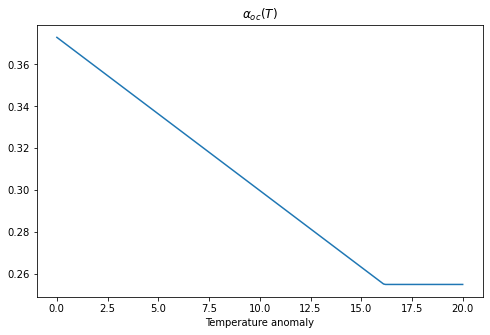

(0.255, 0.372950625)

In [5]:
α_ocean = alphaocean(T_grid + To)
plt.plot(T_grid, α_ocean)
plt.xlabel("Temperature anomaly")
plt.title("$α_{oc}(T)$")
plt.show()
α_ocean.min(), α_ocean.max()

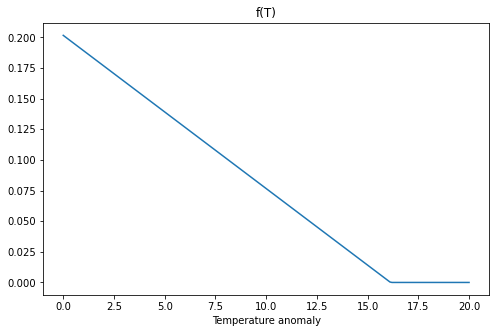

(0.0, 0.20162499999999994)

In [6]:
frac_sea_ice = fracseaice(T_grid + To)
plt.plot(T_grid, frac_sea_ice)
plt.xlabel("Temperature anomaly")
plt.title("f(T)")
plt.show()
frac_sea_ice.min(), frac_sea_ice.max()

In [7]:
frac_sea_ice.mean()

0.08140298507462679

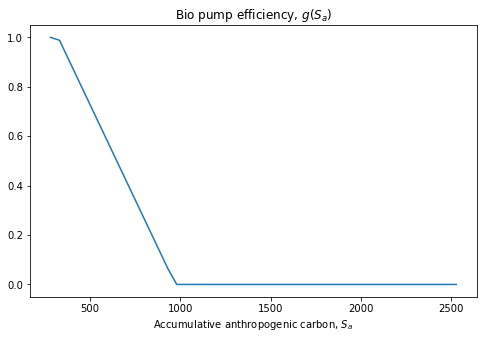

In [8]:
Fo = 272.3 # pre-industrial cumulated emission
bio_pump_efficiency = biopump(F_grid - Fo)
plt.plot(F_grid, bio_pump_efficiency)
plt.xlabel("Accumulative anthropogenic carbon, $S_a$")
plt.title("Bio pump efficiency, $g(S_a)$")
plt.show()

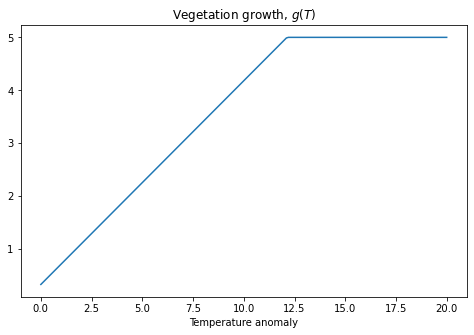

(0.33461538461538637, 5.0)

In [9]:
vege_growth = veggrowth(To + T_grid)


plt.plot(T_grid, vege_growth)
plt.xlabel("Temperature anomaly")
plt.title("Vegetation growth, $g(T)$")
plt.show()

vege_growth.min(), vege_growth.max()

In [10]:
vege_growth.mean()

3.5806352851128977

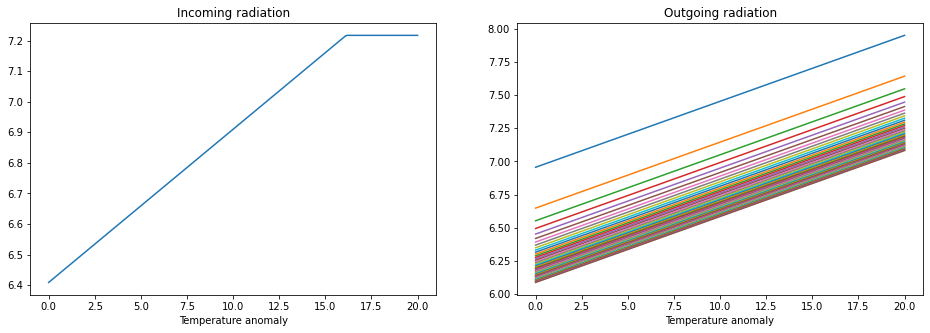

In [11]:
plt.subplots(1,2, figsize=(16, 5))
plt.subplot(121)

plt.title("Incoming radiation")
ri = Ri(To + T_grid)
ro = Ro(To + T_mat[:, 0, :], F_mat[:,0, :] - Fo)
plt.plot(T_grid, ri)
plt.xlabel("Temperature anomaly")

plt.subplot(122)
plt.title("Outgoing radiation")
plt.plot(T_grid, ro)
plt.xlabel("Temperature anomaly")
plt.show()

Text(0.5, 0, 'Temperature anomaly')

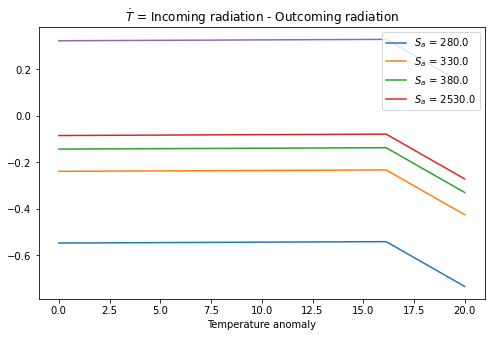

In [12]:
plt.title("$\\dot{T}$ = Incoming radiation - Outcoming radiation")
ri = Ri(To + T_mat[:, 0, :])
ro = Ro(To + T_mat[:, 0, :], F_mat[:,0, :] - Fo)
plt.plot(T_grid, (ri - ro)[:, [0, 1,2,3, -1]])
plt.legend(["$S_a$ = {}".format(F) for F in F_grid[[0, 1, 2,-1]]])
plt.xlabel("Temperature anomaly")

In [13]:
T_grid[5], F_grid[17], C_grid[1]

(0.5, 1130.0, 260)

In [14]:
(ri - ro)[6, 17], 10 * 1.86/1000

(0.17366649657357502, 0.018600000000000002)

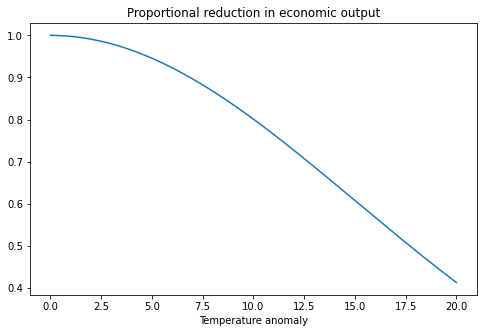

In [15]:
dG  = gamma_1 + gamma_2 * T_grid
G = gamma_1 * T_grid + gamma_2 / 2 * T_grid**2
plt.plot(T_grid, np.exp( -G) )
plt.xlabel("Temperature anomaly")
plt.title("Proportional reduction in economic output")
plt.show()

In [16]:
# Economic paramaters
gamma_1 = 1.7675 / 10000.
gamma_2 = 2 * 0.0022
delta   = 0.01
eta     = 0.032

# State variable
# Temperature anomaly, in celsius
T_min  = 1e-8 
T_max  = 10. # 
hT     = 0.2
T_grid = np.arange(T_min, T_max + hT, hT)

# atmospheric carbon concentration, in ppm
C_min  = 200
C_max  = 400.
hC     = 4.
C_grid = np.arange(C_min, C_max + hC, hC)

# F, Sa in the notes, accumulative anthropogenic carbon, in gigaton, since 1800
F_min = 1e-8 # 10. avoid 
F_max = 2000. # 2500 x2.13 gm # # on hold -> 4000 / 2.13 ppm
hF = 40.
F_grid = np.arange(F_min, F_max + hF, hF)

# meshgrid
(T_mat, C_mat, F_mat) = np.meshgrid(T_grid, C_grid, F_grid, indexing="ij")
stateSpace = np.hstack([
    T_mat.reshape(-1, 1, order="F"),
    C_mat.reshape(-1, 1, order="F"),
    F_mat.reshape(-1, 1, order="F")
])

T_mat.shape

(51, 51, 51)

In [17]:
cearth = 35.
tauc   = 6603.

# v0 = pickle.load(open("data_35.0_6603", "rb"))["v0"]
v0 =  - eta * T_mat - eta * F_mat
# v0 =  delta * eta * np.log(delta /4 * (9000/2.13 - F_mat)) + (eta - 1) * gamma_2 * T_mat / cearth * (B * np.log(C_mat/ C0) + kappa * (T_mat + To - Tkappa))

dG  = gamma_1 + gamma_2 * T_mat
epsilon  = 0.1
count    = 0
error    = 1.
tol      = 1e-8
max_iter = 5000
fraction = 0.1


while error > tol and count < max_iter:
    
    dvdT  = finiteDiff(v0, 0, 1, hT)
    dvdTT = finiteDiff(v0, 0, 2, hT)
    dvdC  = finiteDiff(v0, 1, 1, hC)
#     dvdC[dvdC >= - 1e-16] = - 1e-16
    dvdCC = finiteDiff(v0, 1, 2, hC)
    dvdF  = finiteDiff(v0, 2, 1, hF)
    dvdFF = finiteDiff(v0, 2, 2, hF)
        

    Ca = - eta * delta / (dvdC + dvdF)

    Ca[Ca <= 1e-32] = 1e-32
    
    if count >=1:
        Ca = Ca * fraction + Ca_star * (1 - fraction)
    
#     Ca = np.ones(T_mat.shape)
    A  = - delta * np.ones(T_mat.shape)
    B1 = Ri(T_mat + To) - Ro(T_mat + To, C_mat)
    B2 = Volcan
    B2 += Ca * sa
    B2 -= wa * C_mat * vegcover * veggrowth(T_mat +To)
    B2 += oceanatmphysflux(T_mat + To)  * (1 - fracseaice(T_mat + To))
    B2 += oceanbioflux(T_mat + To, F_mat, sa) * (1 - fracseaice(T_mat + To))
    B2 += oceanatmcorrflux(C_mat) * (1 - fracseaice(T_mat + To))
    B3 = Ca
    C1 = 0.0 * np.ones(T_mat.shape)
    C2 = 0.0 * np.ones(T_mat.shape)
    C3 = np.zeros(T_mat.shape)
    D  = eta * delta * np.log(Ca) + (eta - 1) * dG * B1

    out = PDESolver(stateSpace, A, B1, B2, B3, C1, C2, C3, D, v0, epsilon)
    v = out[2].reshape(v0.shape, order="F")

    rhs_error = A * v0 + B1 * dvdT + B2 * dvdC + B3 * dvdF + C1 * dvdTT + C2 * dvdCC + C3 * dvdFF + D
    rhs_error = np.max(abs(rhs_error))
    lhs_error = np.max(abs((v - v0)/epsilon))

    error = lhs_error
    v0 = v
    Ca_star = Ca
    count += 1

    print("Iteration: %s;\t False Transient Error: %s;\t PDE Error: %s\t" % (count, lhs_error, rhs_error))

print("Total iteration: %s;\t LHS Error: %s;\t RHS Error %s\t" % (count, lhs_error, rhs_error))

Iteration: 1;	 False Transient Error: 0.644178376023774;	 PDE Error: 0.6447965742974096	


Iteration: 2;	 False Transient Error: 0.6435606644261327;	 PDE Error: 0.6441783857158223	


Iteration: 3;	 False Transient Error: 0.6429434298813419;	 PDE Error: 0.6435606741640476	


Iteration: 4;	 False Transient Error: 0.6423266724328869;	 PDE Error: 0.6429434396883265	


Iteration: 5;	 False Transient Error: 0.6417103921123868;	 PDE Error: 0.6423266823240054	


Iteration: 6;	 False Transient Error: 0.6410945889437158;	 PDE Error: 0.6417104020973525	


Iteration: 7;	 False Transient Error: 0.6404792629427902;	 PDE Error: 0.6410945990274681	


Iteration: 8;	 False Transient Error: 0.6398644141207654;	 PDE Error: 0.6404792731274256	


Iteration: 9;	 False Transient Error: 0.6392500424831127;	 PDE Error: 0.6398644244052291	


Iteration: 10;	 False Transient Error: 0.6386361480316793;	 PDE Error: 0.6392500528648488	


Iteration: 11;	 False Transient Error: 0.6380227307647601;	 PDE Error: 0.6386361585067097	


Iteration: 12;	 False Transient Error: 0.6374097906775233;	 PDE Error: 0.6380227413282634	


Iteration: 13;	 False Transient Error: 0.6367973277629346;	 PDE Error: 0.6374098013244445	


Iteration: 14;	 False Transient Error: 0.6361853420125385;	 PDE Error: 0.6367973384879736	


Iteration: 15;	 False Transient Error: 0.6355738334147532;	 PDE Error: 0.6361853528096163	


Iteration: 16;	 False Transient Error: 0.6349628019570019;	 PDE Error: 0.6355738442784884	


Iteration: 17;	 False Transient Error: 0.6343522476252161;	 PDE Error: 0.634962812881975	


Iteration: 18;	 False Transient Error: 0.6337421704041191;	 PDE Error: 0.6343522586061632	


Iteration: 19;	 False Transient Error: 0.6331325702761603;	 PDE Error: 0.6337421814357509	


Iteration: 20;	 False Transient Error: 0.6325234472240027;	 PDE Error: 0.6331325813541329	


Iteration: 21;	 False Transient Error: 0.6319148012281062;	 PDE Error: 0.6325234583435665	


Iteration: 22;	 False Transient Error: 0.6313066322682914;	 PDE Error: 0.6319148123851096	


Iteration: 23;	 False Transient Error: 0.6306989403226027;	 PDE Error: 0.6313066434587887	


Iteration: 24;	 False Transient Error: 0.6300917253691551;	 PDE Error: 0.6306989515433464	


Iteration: 25;	 False Transient Error: 0.6294849873841457;	 PDE Error: 0.6300917366166454	


Iteration: 26;	 False Transient Error: 0.6288787263428475;	 PDE Error: 0.6294849986553768	


Iteration: 27;	 False Transient Error: 0.6282729422200362;	 PDE Error: 0.628878737635255	


Iteration: 28;	 False Transient Error: 0.6276676349889954;	 PDE Error: 0.6282729535308557	


Iteration: 29;	 False Transient Error: 0.6270628046218718;	 PDE Error: 0.6276676463158197	


Iteration: 30;	 False Transient Error: 0.6264584510902438;	 PDE Error: 0.6270628159627263	


Iteration: 31;	 False Transient Error: 0.6258545743641264;	 PDE Error: 0.6264584624431082	


Iteration: 32;	 False Transient Error: 0.6252511744132505;	 PDE Error: 0.6258545857274406	


Iteration: 33;	 False Transient Error: 0.6246482512054286;	 PDE Error: 0.625251185785259	


Iteration: 34;	 False Transient Error: 0.6240458047088993;	 PDE Error: 0.624648262584992	


Iteration: 35;	 False Transient Error: 0.6234438348887039;	 PDE Error: 0.6240458160941332	


Iteration: 36;	 False Transient Error: 0.6228423417108075;	 PDE Error: 0.6234438462790156	


Iteration: 37;	 False Transient Error: 0.6222413251394698;	 PDE Error: 0.6228423531050464	


Iteration: 38;	 False Transient Error: 0.6216407851380978;	 PDE Error: 0.62224133653657	


Iteration: 39;	 False Transient Error: 0.6210407216683933;	 PDE Error: 0.6216407965369722	


Iteration: 40;	 False Transient Error: 0.6204411346919159;	 PDE Error: 0.6210407330685314	


Iteration: 41;	 False Transient Error: 0.6198420241688751;	 PDE Error: 0.6204411460925495	


Iteration: 42;	 False Transient Error: 0.6192433900582728;	 PDE Error: 0.6198420355692782	


Iteration: 43;	 False Transient Error: 0.6186452323181868;	 PDE Error: 0.6192434014579105	


Iteration: 44;	 False Transient Error: 0.6180475509062688;	 PDE Error: 0.6186452437166498	


Iteration: 45;	 False Transient Error: 0.6174503457778258;	 PDE Error: 0.6180475623027495	


Iteration: 46;	 False Transient Error: 0.6168536168885908;	 PDE Error: 0.6174503571723285	


Iteration: 47;	 False Transient Error: 0.6162573641923075;	 PDE Error: 0.6168536282805039	


Iteration: 48;	 False Transient Error: 0.6156615876423643;	 PDE Error: 0.616257375581438	


Iteration: 49;	 False Transient Error: 0.6150662871905865;	 PDE Error: 0.6156615990282325	


Iteration: 50;	 False Transient Error: 0.6144714627880177;	 PDE Error: 0.6150662985729549	


Iteration: 51;	 False Transient Error: 0.6138771143847066;	 PDE Error: 0.6144714741667029	


Iteration: 52;	 False Transient Error: 0.6132832419299206;	 PDE Error: 0.6138771257595119	


Iteration: 53;	 False Transient Error: 0.6126898453711505;	 PDE Error: 0.6132832533004423	


Iteration: 54;	 False Transient Error: 0.6120969246560293;	 PDE Error: 0.6126898567374964	


Iteration: 55;	 False Transient Error: 0.6115044797299873;	 PDE Error: 0.6120969360177496	


Iteration: 56;	 False Transient Error: 0.6109125105383839;	 PDE Error: 0.6115044910871764	


Iteration: 57;	 False Transient Error: 0.6103210170252993;	 PDE Error: 0.6109125218907936	


Iteration: 58;	 False Transient Error: 0.6097299991332505;	 PDE Error: 0.6103210283726666	


Iteration: 59;	 False Transient Error: 0.6091394568048258;	 PDE Error: 0.609730010475756	


Iteration: 60;	 False Transient Error: 0.6085493899804817;	 PDE Error: 0.6091394681420875	


Iteration: 61;	 False Transient Error: 0.6079597986006036;	 PDE Error: 0.6085494013126368	


Iteration: 62;	 False Transient Error: 0.6073706826040848;	 PDE Error: 0.6079598099274545	


Iteration: 63;	 False Transient Error: 0.6067820419286818;	 PDE Error: 0.6073706939255407	


Iteration: 64;	 False Transient Error: 0.6061938765119379;	 PDE Error: 0.6067820532449487	


Iteration: 65;	 False Transient Error: 0.6056061862897621;	 PDE Error: 0.6061938878227291	


Iteration: 66;	 False Transient Error: 0.6050189711969267;	 PDE Error: 0.6056061975949572	


Iteration: 67;	 False Transient Error: 0.6044322311677064;	 PDE Error: 0.6050189824966383	


Iteration: 68;	 False Transient Error: 0.603845966135168;	 PDE Error: 0.6044322424619257	


Iteration: 69;	 False Transient Error: 0.6032601760318101;	 PDE Error: 0.6038459774238506	


Iteration: 70;	 False Transient Error: 0.6026748607879995;	 PDE Error: 0.6032601873146244	


Iteration: 71;	 False Transient Error: 0.6020900203346002;	 PDE Error: 0.6026748720653169	


Iteration: 72;	 False Transient Error: 0.6015056546004871;	 PDE Error: 0.602090031606149	


Iteration: 73;	 False Transient Error: 0.6009217635138953;	 PDE Error: 0.6015056658663092	


Iteration: 74;	 False Transient Error: 0.6003383470023493;	 PDE Error: 0.6009217747740674	


Iteration: 75;	 False Transient Error: 0.5997554049916687;	 PDE Error: 0.6003383582566504	


Iteration: 76;	 False Transient Error: 0.5991729374076016;	 PDE Error: 0.5997554162403467	


Iteration: 77;	 False Transient Error: 0.5985909441744042;	 PDE Error: 0.5991729486505201	


Iteration: 78;	 False Transient Error: 0.5980094252154089;	 PDE Error: 0.5985909554115159	


Iteration: 79;	 False Transient Error: 0.5974283804533087;	 PDE Error: 0.5980094364467614	


Iteration: 80;	 False Transient Error: 0.5968478098089491;	 PDE Error: 0.5974283916787368	


Iteration: 81;	 False Transient Error: 0.5962677132036731;	 PDE Error: 0.5968478210288453	


Iteration: 82;	 False Transient Error: 0.595688090556763;	 PDE Error: 0.5962677244176962	


Iteration: 83;	 False Transient Error: 0.5951089417867195;	 PDE Error: 0.595688101764854	


Iteration: 84;	 False Transient Error: 0.5945302668113328;	 PDE Error: 0.5951089529889932	


Iteration: 85;	 False Transient Error: 0.5939520655472563;	 PDE Error: 0.5945302780077831	


Iteration: 86;	 False Transient Error: 0.5933743379105749;	 PDE Error: 0.5939520767379546	


Iteration: 87;	 False Transient Error: 0.5927970838159524;	 PDE Error: 0.5933743490953509	


Iteration: 88;	 False Transient Error: 0.5922203031770579;	 PDE Error: 0.592797094994799	


Iteration: 89;	 False Transient Error: 0.5916439959073472;	 PDE Error: 0.5922203143502366	


Iteration: 90;	 False Transient Error: 0.5910681619185709;	 PDE Error: 0.591644007074593	


Iteration: 91;	 False Transient Error: 0.5904928011219823;	 PDE Error: 0.5910681730799966	


Iteration: 92;	 False Transient Error: 0.5899179134275556;	 PDE Error: 0.590492812277533	


Iteration: 93;	 False Transient Error: 0.5893434987446966;	 PDE Error: 0.5899179245773474	


Iteration: 94;	 False Transient Error: 0.5887695569819584;	 PDE Error: 0.5893435098887413	


Iteration: 95;	 False Transient Error: 0.5881960880463311;	 PDE Error: 0.588769568120017	


Iteration: 96;	 False Transient Error: 0.5876230918445202;	 PDE Error: 0.5881960991785663	


Iteration: 97;	 False Transient Error: 0.5870505682818106;	 PDE Error: 0.587623102970872	


Iteration: 98;	 False Transient Error: 0.5864785172632736;	 PDE Error: 0.5870505794024788	


Iteration: 99;	 False Transient Error: 0.5859069386924176;	 PDE Error: 0.5864785283780255	


Iteration: 100;	 False Transient Error: 0.5853358324716851;	 PDE Error: 0.5859069498012461	


Iteration: 101;	 False Transient Error: 0.5847651985036606;	 PDE Error: 0.5853358435748988	


Iteration: 102;	 False Transient Error: 0.5841950366887261;	 PDE Error: 0.5847652096009046	


Iteration: 103;	 False Transient Error: 0.5836253469273345;	 PDE Error: 0.5841950477802361	


Iteration: 104;	 False Transient Error: 0.5830561291184466;	 PDE Error: 0.5836253580129892	


Iteration: 105;	 False Transient Error: 0.5824873831604549;	 PDE Error: 0.5830561401983039	


KeyboardInterrupt: 

In [25]:
cearth, tauc

(35.0, 6603.0)

In [26]:
B1.max(), B1.min(), v0.min(), v0.mean(), v0.max(), Ca.min(), Ca.max(), v0.mean(), v0.std(), v0.max(), v0.min()

(0.2307949814522381,
 -0.235433613809243,
 -0.6199428206087964,
 -0.1792420527478804,
 0.553647826960972,
 1.654656126606999e-10,
 715.6085607265715,
 -0.1792420527478804,
 0.20961160637244367,
 0.553647826960972,
 -0.6199428206087964)

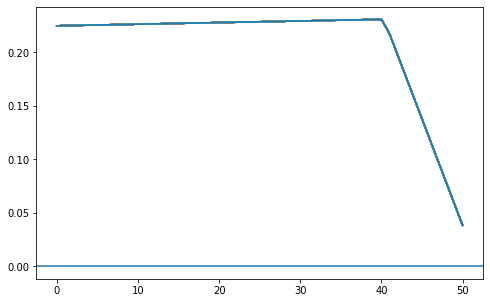

In [27]:
plt.plot(B1[:, -1, :])
plt.axhline(0)
plt.show()

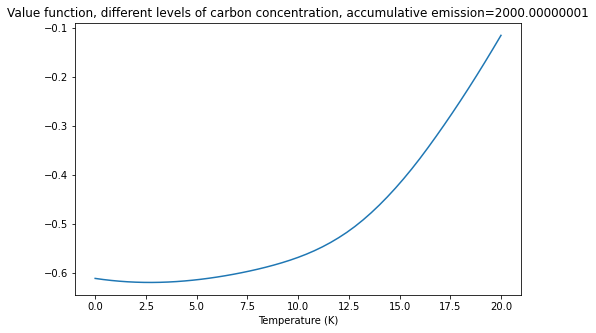

In [28]:
ii = -1
plt.plot(T_grid, v0[:, -1, ii])
plt.xlabel("Temperature (K)")
plt.title("Value function, different levels of carbon concentration, accumulative emission={}".format(F_grid[ii]))
plt.show()

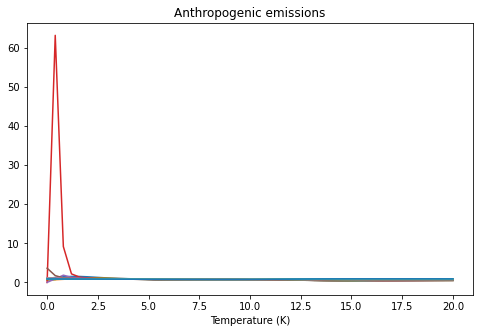

In [29]:
plt.plot(T_grid, Ca[:, :, 6])
plt.xlabel("Temperature (K)")
plt.title("Anthropogenic emissions")
plt.show()

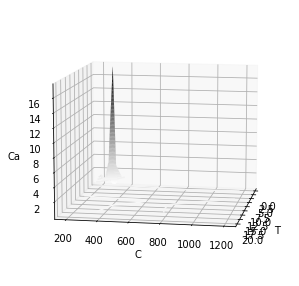

In [30]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(T_mat[:, :, 10], C_mat[:, :, 10], Ca[:, :, ii], 90, cmap='binary')
ax.set_xlabel('T')
ax.set_ylabel('C')
ax.set_zlabel('Ca')
ax.view_init(10, 10)

In [2]:
(870 - 580) / 2.13

136.15023474178403

In [31]:
t_max = 600.
dt = 1/12
dt = 1  # , Gigaton per year
gridpoints = (T_grid, C_grid, F_grid)   
Ca_func = RegularGridInterpolator(gridpoints, Ca)

T_0 = To + min(T_grid)
C_0 = 275.5
F_0 = min(F_grid) #(870 - 580) / 2.13 # total cumulated, as of now, preindustrial with Fo

T_0 = To + 1.1
C_0 = 417
F_0 = (870 - 580) / 2.13

def get_e(x):
    return Ca_func([x[0] - To, x[1], x[2]])

# Ocean albedo
def alphaocean_1d(T):
    if T < Talphaocean_low:
        return alphaocean_max
    elif T < Talphaocean_high:
        return alphaocean_max + (alphaocean_min - alphaocean_max) / (Talphaocean_high - Talphaocean_low) * (T - Talphaocean_low)
    else: # so T is higher
        return alphaocean_min

# Vegetation growth function
def veggrowth_1d(T):
    if T < Tlow:
        return 0
    if (T >= Tlow) and (T < Topt1):
        return acc / (Topt1 - Tlow) * (T - Tlow)
    if (T >= Topt1) and (T <= Topt2):
        return acc
    if (T > Topt2) and (T < Thigh):
        #return acc
        return acc / (Topt2 - Thigh) * (T - Thigh)
    if T > Thigh:
        #return acc
        return 0

def oceanatmphysflux_1d(T):
    return 1 / tauc * (coc0 * (np.exp(-bP * (T - T0))))

def fracseaice_1d(T):
    if T < Talphaocean_low:
        return 1
    elif T < Talphaocean_high:
        return 1 - 1 / (Talphaocean_high - Talphaocean_low) * (T - Talphaocean_low)
    else: # so T is higher
        return 0

def biopump_1d(Cc):
    if Cc < Cbio_low:
        return 1
    elif Cc < Cbio_high:
        return 1 - 1 / (Cbio_high - Cbio_low) * (Cc - Cbio_low)
    else: 
        return 0


def oceanbioflux_1d(T, F, sa):
     return 1/tauc * (coc0 * (np.exp(bB * biopump_1d(F) * (T - T0))))

def oceanatmcorrflux_1d(C):
    return 1 / tauc * (- cod * C)


def mu_T(x):
    Ri_t = 1 / cearth * (Q0 * (1 - p * alphaland - (1 - p) * alphaocean(x[0])))
    Ro_t = 1 / cearth * (kappa * (x[0] - Tkappa) -  B * np.log(x[1] / C0))
    return Ri_t - Ro_t

def mu_C(x):
    Ca_t = Ca_func([x[0] - To, x[1], x[2]])
    dC = Volcan
    dC += Ca_t * sa
    dC -= wa * x[1] * vegcover * veggrowth_1d(x[0])
    dC += oceanatmphysflux_1d(x[0]) * (1 - fracseaice_1d(x[0]))
    dC += oceanbioflux_1d(x[0], x[2], sa) * (1 - fracseaice_1d(x[0]))
    dC += oceanatmcorrflux_1d(x[1]) * (1 - fracseaice_1d(x[0]))
    return dC

def mu_Sa(x):
    return Ca_func([x[0] - To, x[1], x[2]])

years  = np.arange(0, t_max + dt, dt)
pers   = len(years)

hist      = np.zeros([pers, 3])
e_hist    = np.zeros([pers])


for tm in range(pers):
    if tm == 0:
        # initial points
        hist[0,:] = [T_0, C_0, F_0] # logL
        e_hist[0] = get_e(hist[0, :])

    else:
        # other periods
        e_hist[tm] = get_e(hist[tm-1,:])

        hist[tm,0] = max(hist[tm-1,0] + mu_T(hist[tm-1,:]) * dt, To + min(T_grid))
        hist[tm,1] = hist[tm-1,1] + mu_C(hist[tm-1,:]) * dt
        hist[tm,2] = hist[tm-1,2] + mu_Sa(hist[tm-1,:]) * dt


In [32]:
min(T_grid), hist

(1e-08,
 array([[283.97      , 417.        , 136.15023474],
        [284.03361896, 415.98802531, 137.0585891 ],
        [284.09689046, 414.91776171, 137.96497819],
        ...,
        [282.87000001, 241.78999755, 513.87359552],
        [282.87000001, 241.9813725 , 514.49104234],
        [282.87000001, 242.17230949, 515.10847123]]))

Text(0.5, 1.0, '$S_a$')

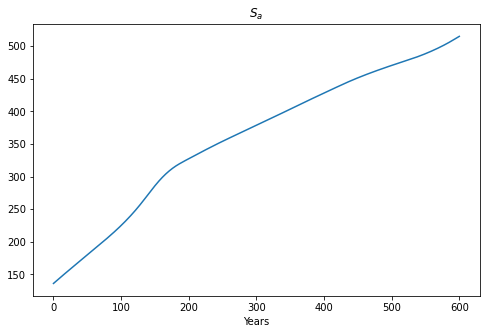

In [33]:
plt.plot(years[:], hist[:, 2])
plt.xlabel("Years")
plt.title("$S_a$")

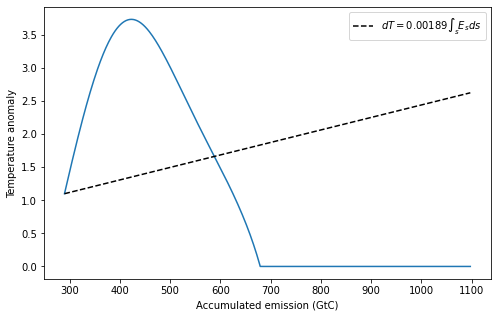

In [34]:
plt.plot(hist[:, 2] * 2.13, hist[:, 0] - To)
plt.plot(hist[:, 2] * 2.13, 1.1 +  (hist[:, 2] - hist[0, 2]) * 2.13 * 0.00189, 
         linestyle="dashed", color="black", label="$dT = 0.00189 \int_s E_s ds$")
plt.xlabel("Accumulated emission (GtC)")
plt.ylabel("Temperature anomaly")
plt.legend()
# plt.savefig("T_F_35.pdf")

In [35]:
e_hist

array([0.90835436, 0.90835436, 0.9063891 , 0.90450251, 0.90272339,
       0.90094833, 0.89917659, 0.89740745, 0.89564027, 0.89387448,
       0.89229091, 0.89072181, 0.8891609 , 0.8876081 , 0.88608654,
       0.88463859, 0.88320844, 0.88192822, 0.88065754, 0.87939647,
       0.87814508, 0.87690352, 0.87567195, 0.87445058, 0.87333332,
       0.87233656, 0.87141923, 0.87051508, 0.86962445, 0.8687481 ,
       0.86788574, 0.8670377 , 0.86622614, 0.86547264, 0.86479524,
       0.86427459, 0.86376939, 0.86327999, 0.86280677, 0.86235014,
       0.86191053, 0.86148838, 0.8610821 , 0.86084919, 0.86072734,
       0.86061922, 0.86052556, 0.8604471 , 0.86038461, 0.86033888,
       0.86031072, 0.86034021, 0.86066746, 0.8609978 , 0.86133321,
       0.86167568, 0.86202722, 0.86238984, 0.8627562 , 0.86314235,
       0.86370687, 0.86448712, 0.86528087, 0.86609082, 0.86691962,
       0.86776988, 0.8686442 , 0.86954511, 0.87047511, 0.87168079,
       0.87365051, 0.87564216, 0.87766034, 0.87970951, 0.88179

(-0.1, 2.981972221371938)

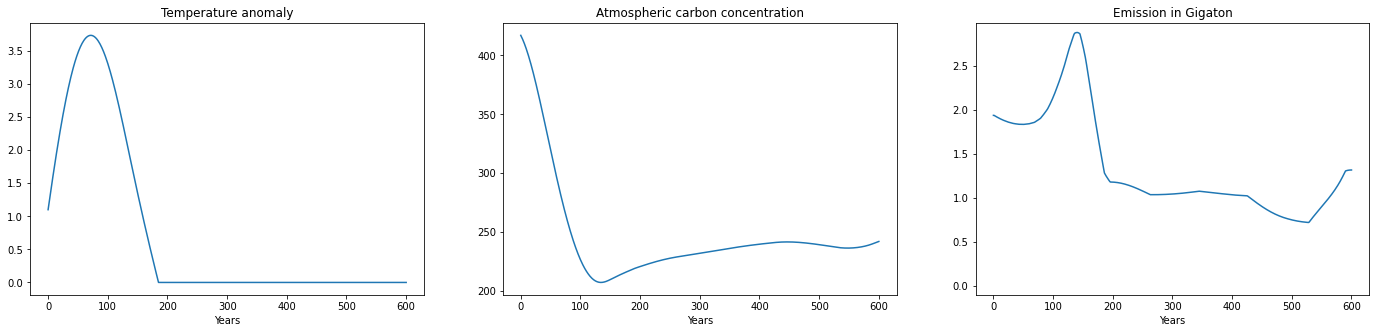

In [36]:
plt.subplots(1,3, figsize=(24,5))
plt.subplot(131)
plt.plot(years, hist[:, 0] - To)
plt.xlabel("Years")
plt.title("Temperature anomaly")
plt.subplot(132)
plt.plot(years, hist[:, 1])
plt.xlabel("Years")
plt.title("Atmospheric carbon concentration")
plt.subplot(133)
plt.plot(years, e_hist * 2.13)
plt.xlabel("Years")
plt.title("Emission in Gigaton")
plt.ylim(-0.1)
# plt.savefig(f"T_C_E_{cearth}_{tauc}.pdf")

In [96]:
res = {
    "v0": v0,
    "T": T_grid,
    "C": C_grid,
    "F": F_grid,
    "Ca": Ca,
}

pickle.dump(res, open(f"./data_{cearth}_{tauc}", "wb"))

In [409]:
Et = e_hist * 2.13

Text(0.5, 1.0, 'Emission in GtC')

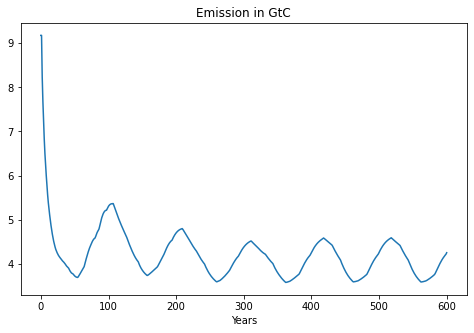

In [410]:
plt.plot(years, Et)
plt.xlabel("Years")
plt.title("Emission in GtC")

In [35]:
# df = pd.DataFrame({
#     'Years': years,
#     'Et(Gigaton)': Et,
#                   })

# df.to_csv("Et.csv", index=False)